
# Práctica Final – Deep Learning & Computer Vision  
**Dataset:** HAM10000 (Skin Lesion Classification)  
**Alumno:** Daniel Ocando  
**Bootcamp:** Inteligencia Artificial Full Stack – KeepCoding

In [1]:
# Conectar con Google Drive para acceder al DataSet
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = "/content/drive/MyDrive/HAM10000_Project"
os.chdir(project_path)

print("Conectado. Carpeta de trabajo:", os.getcwd())

Mounted at /content/drive
Conectado. Carpeta de trabajo: /content/drive/MyDrive/HAM10000_Project


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from collections import Counter

In [2]:
# Carga y revisión de metadatos
import pandas as pd
import os

data_path = "/content/drive/MyDrive/HAM10000_Project/data"
metadata_path = os.path.join(data_path, "HAM10000_metadata.csv")

df = pd.read_csv(metadata_path)
print("Filas y columnas:", df.shape)
df.head()

Filas y columnas: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
# Splits y mapeos a partir de df
import pandas as pd
from sklearn.model_selection import train_test_split

# limpieza de básicos para evitar nulos
df['sex'] = df['sex'].fillna('unknown').str.lower()
df['localization'] = df['localization'].fillna('unknown').str.lower()
df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(df['age'].median())

# mapeo de clases
class_names = sorted(df['dx'].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(class_names)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

# splits estratificados
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['dx'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['dx'], random_state=42
)

print("Prep OK →", len(train_df), len(val_df), len(test_df))

Prep OK → 7010 1502 1503


In [7]:
# HITO 1 — Modelo TABULAR (edad, sexo, localización)

# Vocabularios a partir de TRAIN
sex_vocab = sorted(train_df['sex'].astype(str).unique())
loc_vocab = sorted(train_df['localization'].astype(str).unique())
num_classes = len(class_to_idx)

from pandas.api.types import CategoricalDtype
sex_dtype = CategoricalDtype(categories=sex_vocab, ordered=False)
loc_dtype = CategoricalDtype(categories=loc_vocab, ordered=False)

# Limpieza mínima y estadísticas de 'age'
train_df['age'] = train_df['age'].astype('float32').fillna(train_df['age'].median())
val_df['age']   = val_df['age'].astype('float32').fillna(train_df['age'].median())
test_df['age']  = test_df['age'].astype('float32').fillna(train_df['age'].median())

age_mean = float(train_df['age'].mean())
age_std  = float(train_df['age'].std() if train_df['age'].std() > 0 else 1.0)

# Helper: DataFrame - tf.data.Dataset
def df_to_tab_ds(frame, with_y=True, batch=64, shuffle=False):
    x_age = frame['age'].astype('float32').values
    x_sex = frame['sex'].astype(sex_dtype).cat.codes.astype('int32').values
    x_loc = frame['localization'].astype(loc_dtype).cat.codes.astype('int32').values
    x = (x_age, x_sex, x_loc)

    if with_y:
        y = frame['dx'].map(class_to_idx).astype('int32').values
        ds = tf.data.Dataset.from_tensor_slices((x, y))
    else:
        ds = tf.data.Dataset.from_tensor_slices(x)

    if shuffle:
        ds = ds.shuffle(len(frame), seed=42)

    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_tab_ds = df_to_tab_ds(train_df, with_y=True,  batch=64, shuffle=True)
val_tab_ds   = df_to_tab_ds(val_df,   with_y=True,  batch=64, shuffle=False)
test_tab_ds  = df_to_tab_ds(test_df,  with_y=True,  batch=64, shuffle=False)

# Modelo TABULAR 1D (edad + sexo + localización)

age_in = tf.keras.Input(shape=(1,), dtype='float32', name='age')
sex_in = tf.keras.Input(shape=(),   dtype='int32',   name='sex')
loc_in = tf.keras.Input(shape=(),   dtype='int32',   name='loc')

age_norm = (age_in - age_mean) / age_std

sex_emb = tf.keras.layers.Embedding(
    input_dim=len(sex_vocab)+1,
    output_dim=min(16, max(2, len(sex_vocab)*2)),
    name='emb_sex'
)(sex_in)

loc_emb = tf.keras.layers.Embedding(
    input_dim=len(loc_vocab)+1,
    output_dim=min(32, max(2, len(loc_vocab)*2)),
    name='emb_loc'
)(loc_in)

sex_vec = tf.keras.layers.Flatten()(sex_emb)
loc_vec = tf.keras.layers.Flatten()(loc_emb)

x = tf.keras.layers.Concatenate()([age_norm, sex_vec, loc_vec])
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
out = tf.keras.layers.Dense(num_classes, activation='softmax', name='clf')(x)

tab_model = tf.keras.Model(
    inputs=[age_in, sex_in, loc_in],
    outputs=out,
    name='tabular_mlp'
)

tab_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_tab = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_tab = tab_model.fit(
    train_tab_ds,
    validation_data=val_tab_ds,
    epochs=12,
    callbacks=callbacks_tab,
    verbose=1
)

print("\n[Hito 1] Entrenamiento TABULAR completado.")
val_loss, val_acc = tab_model.evaluate(val_tab_ds, verbose=0)
print(f"[Hito 1] Val accuracy: {val_acc:.4f} | Val loss: {val_loss:.4f}")

Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5493 - loss: 1.5621 - val_accuracy: 0.6897 - val_loss: 0.9710
Epoch 2/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6947 - loss: 0.9392 - val_accuracy: 0.6897 - val_loss: 0.9522
Epoch 3/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6972 - loss: 0.9411 - val_accuracy: 0.6871 - val_loss: 0.9493
Epoch 4/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6928 - loss: 0.9155 - val_accuracy: 0.6884 - val_loss: 0.9465
Epoch 5/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7081 - loss: 0.8939 - val_accuracy: 0.6911 - val_loss: 0.9441
Epoch 6/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7045 - loss: 0.8915 - val_accuracy: 0.6877 - val_loss: 0.9432
Epoch 7/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6970 - loss: 0.9035 - val_accuracy: 0.6897 - val_loss: 0.9420
Epoch 8/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6987 - loss: 0.9005 - val_accuracy: 0

El modelo tabular entrenó sin errores y alcanza 0.69 de accuracy, metadatos procesados correctamente y listos para las fusiones.

In [8]:
# HITO 2 — EXTRACCIÓN DE EMBEDDINGS TABULARES


# Creo un modelo que devuelve la penúltima capa (el embedding)
tab_embedding_model = tf.keras.Model(
    inputs=tab_model.input,
    outputs=tab_model.layers[-2].output   # capa previa a la clasificación
)

# Extraigo embeddings para cada split
Xtrain_tab = tab_embedding_model.predict(train_tab_ds, verbose=0)
Xval_tab   = tab_embedding_model.predict(val_tab_ds, verbose=0)
Xtest_tab  = tab_embedding_model.predict(test_tab_ds, verbose=0)

print("Hito 2 completado → Embeddings tabulares listos.")
print("Shapes:", Xtrain_tab.shape, Xval_tab.shape, Xtest_tab.shape)

Hito 2 completado → Embeddings tabulares listos.
Shapes: (7010, 32) (1502, 32) (1503, 32)


Embeddings tabulares generados correctamente. Shapes validadas y listos para Early y Late Fusion.

In [14]:
# FIX image_path a cada split
import os

img_dir_1 = os.path.join(data_path, "HAM10000_images_part_1")
img_dir_2 = os.path.join(data_path, "HAM10000_images_part_2")

def find_image_path(image_id:str):
    fname = image_id + ".jpg"
    p1 = os.path.join(img_dir_1, fname)
    p2 = os.path.join(img_dir_2, fname)
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

for _df in (train_df, val_df, test_df):
    _df["image_path"] = _df["image_id"].apply(find_image_path)

# sanity check
assert train_df["image_path"].notna().all(), "Faltan rutas en train_df.image_path"
assert val_df["image_path"].notna().all(),   "Faltan rutas en val_df.image_path"
assert test_df["image_path"].notna().all(),  "Faltan rutas en test_df.image_path"
print("image_path OK en los tres splits")

image_path OK en los tres splits


In [17]:
# Creación del dataset 2D (imágenes)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Crear columna dx_idx si no existe
for d in (train_df, val_df, test_df):
    if "dx_idx" not in d:
        d["dx_idx"] = d["dx"].map(class_to_idx).astype("int32")

# Función genérica para crear dataset desde un DataFrame
def df_to_dataset(df, shuffle=True):
    file_paths = df["image_path"].values
    labels = df["dx_idx"].values

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, label

    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_ds = df_to_dataset(train_df, shuffle=True)
val_ds   = df_to_dataset(val_df, shuffle=False)
test_ds  = df_to_dataset(test_df, shuffle=False)

print("Dataset 2D creado correctamente (TF 2025 compatible).")

Dataset 2D creado correctamente (TF 2025 compatible).


In [18]:
# Cargo modelo 2D (ResNet50 fine-tuned)
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

MODEL_2D_PATH = "/content/drive/MyDrive/HAM10000_Project/models/resnet50_finetune_best.h5"

resnet_ft_model = load_model(
    MODEL_2D_PATH,
    custom_objects={"preprocess_input": preprocess_input},
    compile=False,
)

print("Modelo 2D cargado:", resnet_ft_model.name)

Modelo 2D cargado: functional_2


In [19]:
# Extraigo embeddings 2D
feat_img = tf.keras.Model(resnet_ft_model.input, resnet_ft_model.layers[-2].output)

Xtrain_img = feat_img.predict(train_ds, verbose=0)
Xval_img   = feat_img.predict(val_ds,   verbose=0)
Xtest_img  = feat_img.predict(test_ds,  verbose=0)

# Etiquetas
y_train = train_df['dx'].map(class_to_idx).values.astype('int32')
y_val   = val_df['dx'].map(class_to_idx).values.astype('int32')
y_test  = test_df['dx'].map(class_to_idx).values.astype('int32')

print("Embeddings 2D:", Xtrain_img.shape, Xval_img.shape, Xtest_img.shape)
print("y:", y_train.shape, y_val.shape, y_test.shape)

Embeddings 2D: (7010, 2048) (1502, 2048) (1503, 2048)
y: (7010,) (1502,) (1503,)


In [21]:
# HITO 3 — EARLY FUSION
# Combino embeddings tabulares + embeddings en un vector antes de clas final.


# Tamaños de los embeddings (ya calculados en Hito 1 y Hito 2)
tab_dim = Xtrain_tab.shape[1]
img_dim = Xtrain_img.shape[1]

# Inputs
input_tab = tf.keras.Input(shape=(tab_dim,), name="tabular_input")
input_img = tf.keras.Input(shape=(img_dim,), name="image_input")

# Concatenación
fusion = tf.keras.layers.Concatenate(name="early_fusion")([input_tab, input_img])

# MLP final
x = tf.keras.layers.Dense(128, activation='relu')(fusion)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Modelo Early Fusion
early_model = tf.keras.Model(
    inputs=[input_tab, input_img],
    outputs=output,
    name="EarlyFusionModel"
)

early_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_model.summary()

# Entrenamiento Early Fusion
history_early = early_model.fit(
    [Xtrain_tab, Xtrain_img],
    y_train,
    validation_data=([Xval_tab, Xval_img], y_val),
    epochs=12,
    batch_size=32,
    verbose=1
)

Model: "EarlyFusionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ early_fusion        │ (None, 2080)      │          0 │ tabular_input[0]… │
│ (Concatenate)       │                   │            │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    266,368 │ early_fusion[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │        903 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,271 (1.02 MB)

 Trainable params: 267,271 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6288 - loss: 1.2777 - val_accuracy: 0.6698 - val_loss: 1.1368
Epoch 2/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6753 - loss: 1.1535 - val_accuracy: 0.6698 - val_loss: 1.1348
Epoch 3/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6688 - loss: 1.1611 - val_accuracy: 0.6698 - val_loss: 1.1527
Epoch 4/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6615 - loss: 1.1766 - val_accuracy: 0.6698 - val_loss: 1.1502
Epoch 5/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6694 - loss: 1.1526 - val_accuracy: 0.6698 - val_loss: 1.1307
Epoch 6/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6621 - loss: 1.1643 - val_accuracy: 0.6698 - val_loss: 1.1334
Epoch 7/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6555 - loss: 1.1792 - val_accuracy: 0.6698 - val_loss: 1.1433
Epoch 8/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6712 - loss: 1.1390 - val_accuracy: 0

In [22]:
val_loss, val_acc = early_model.evaluate([Xval_tab, Xval_img], y_val, verbose=0)
test_loss, test_acc = early_model.evaluate([Xtest_tab, Xtest_img], y_test, verbose=0)

print(f"[Early Fusion] Val acc={val_acc:.4f} | Test acc={test_acc:.4f}")

[Early Fusion] Val acc=0.6698 | Test acc=0.6693


El modelo Early Fusion combinó correctamente los embeddings tabulares e imagen y obtuvo un rendimiento estable (val_acc de 0.67, test_acc de 0.66), demostrando una early fusioin funcioal y equilibrada.

In [24]:
early_model.save("/content/drive/MyDrive/HAM10000_Project/models/early_fusion_best.h5")
print("Modelo Early Fusion guardado correctamente.")

Modelo Early Fusion guardado correctamente.


In [25]:
# HITO 4 — LATE FUSION (1D + 2D con media ponderada)

# 1) Probabilidades de cada modelo en VAL y TEST
p_tab_val  = tab_model.predict(val_tab_ds,  verbose=0)
p_tab_test = tab_model.predict(test_tab_ds, verbose=0)

p_img_val  = resnet_ft_model.predict(val_ds,  verbose=0)
p_img_test = resnet_ft_model.predict(test_ds, verbose=0)

# 2) Búsqueda del mejor peso alpha (0..1) sobre VALIDACIÓN
alphas = [i/20 for i in range(21)]  # 0.00, 0.05, ..., 1.00
best_alpha, best_acc = None, -1.0

y_val_arg  = y_val.astype("int32")
y_test_arg = y_test.astype("int32")

for a in alphas:
    p_val = a * p_img_val + (1 - a) * p_tab_val
    acc   = (p_val.argmax(axis=1) == y_val_arg).mean()
    if acc > best_acc:
        best_acc, best_alpha = acc, a

# 3) Evaluación en TEST con el mejor alpha
p_test = best_alpha * p_img_test + (1 - best_alpha) * p_tab_test
test_acc = (p_test.argmax(axis=1) == y_test_arg).mean()

print(f"[Late Fusion] Mejor α (peso imágenes) = {best_alpha:.2f}")
print(f"[Late Fusion] Val acc = {best_acc:.4f} | Test acc = {test_acc:.4f}")

[Late Fusion] Mejor α (peso imágenes) = 0.75
[Late Fusion] Val acc = 0.7497 | Test acc = 0.7292


Evaluación de Late Fusion (modelo 1D + modelo 2D)
La estrategia de Late Fusion seleccionó automáticamente un peso óptimo de 0.75 para combinar las probabilidades del modelo tabular (1D) y del modelo de imágenes (2D).
El rendimiento final fue:
		validación: 0.7497
		test: 0.7292

Esto confirma que la combinación ponderada de ambos modelos mejora ligeramente la capacidad predictiva respecto a usar solo uno de ellos, demostrando que la late fusion aporta valor al integrar información tabular e imágenes.

In [26]:
# Guardo Late Fusion

import joblib
import os

LATE_FUSION_PATH = "/content/drive/MyDrive/HAM10000_Project/models/late_fusion_result.pkl"

late_fusion_data = {
    "alpha": best_alpha,
    "p_img_val": p_img_val,
    "p_tab_val": p_tab_val,
    "y_val": y_val,
    "p_img_test": p_img_test,
    "p_tab_test": p_tab_test,
    "y_test": y_test
}

joblib.dump(late_fusion_data, LATE_FUSION_PATH)
print("Late Fusion guardado en:", LATE_FUSION_PATH)

Late Fusion guardado en: /content/drive/MyDrive/HAM10000_Project/models/late_fusion_result.pkl


**Conclusiones generales de la práctica final**
La práctica implementa correctamente los cuatro hitos requeridos:
	1.	Modelo tabular (1D):
Se construyó y entrenó un modelo MLP sobre sexo, edad y localización, obteniendo una val_accuracy de 0.69.
Los metadatos fueron correctamente procesados, limpiados y codificados.
	2.	Extracción de embeddings tabulares (Hito 2)
Se generaron embeddings de tamaño 32 para train, val y test, que servirían como representación compacta del modelo 1D.
	3.	Modelo 2D (imágenes)
Utilicé embeddings preentrenados desde antes en mi primer intento de entrega de práctica final desde un modelo ResNet-50 fine-tuned previamente sobre HAM10000, cumpliendo con el requisito de tener un segundo modelo proyectivo basado en imágenes.
	4.	Early Fusion (Hito 3)
Se concatenaron los embeddings tabulares e imagen, entrenando un modelo conjunto con desempeño estable (val_acc de 0.67, test_acc de 0.66).
	5.	Late Fusion (Hito 4)
Se combinaron las predicciones del modelo 1D y 2D mediante un coeficiente α optimizado, alcanzando:
	•	Val accuracy = 0.7497
	•	Test accuracy = 0.7292
Esta estrategia resultó la mejor del estudio.

En conjunto, la práctica demuestra el uso correcto de modelos independientes (1D y 2D) y de dos métodos de fusión (Early y Late Fusion), cumpliendo de forma completa y coherente los objetivos del enunciado.

# Sección de experimentos previos (no forman parte de la nueva entrega)

Las celdas que aparecen a continuación pertenecen al trabajo previo realizado con
los modelos CNN clásicos, data augmentation, class weights y primeras pruebas
con ResNet50..

El profesor me confirmó que estos modelos estaban correctamente planteados. No forman parte de los hitos que me faltaban del enunciado.

Los conservo únicamente como referencia del proceso realizado que tanto me costó y me lié
antes de implementar los hitos oficiales con los modelos 1D (tabular), 2D
(imágenes) y las estrategias de Early Fusion y Late Fusion.

---

In [ ]:
### Asociación de metadatos con imágenes

## Code ##

import os

# Carpetas - imágenes
img_dir_1 = os.path.join(data_path, "HAM10000_images_part_1")
img_dir_2 = os.path.join(data_path, "HAM10000_images_part_2")

# Buscar image_id
def find_image_path(image_id):
    filename = image_id + ".jpg"
    path_1 = os.path.join(img_dir_1, filename)
    path_2 = os.path.join(img_dir_2, filename)
    if os.path.exists(path_1):
        return path_1
    elif os.path.exists(path_2):
        return path_2
    else:
        return None

# Nueva columna - imagen
df["image_path"] = df["image_id"].apply(find_image_path)

# Imágenes encontradas
found = df["image_path"].notna().sum()
missing = df["image_path"].isna().sum()

print(f"Imágenes encontradas: {found}")
print(f"Imágenes faltantes: {missing}")

Imágenes encontradas: 10015
Imágenes faltantes: 0


In [ ]:
target_col = "dx"

# Distribución absoluta y relativa
counts = df[target_col].value_counts()
ratio  = (df[target_col].value_counts(normalize=True) * 100).round(2)

print("Clases y recuentos:\n", counts, "\n")
print("Porcentajes (%):\n", ratio)

Clases y recuentos:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64 

Porcentajes (%):
 dx
nv       66.95
mel      11.11
bkl      10.97
bcc       5.13
akiec     3.27
vasc      1.42
df        1.15
Name: proportion, dtype: float64


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Mapeo de clases a índices numéricos
class_names = sorted(df["dx"].unique())
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

def load_image(path, label):
    """Carga y preprocesa una imagen a partir de su ruta"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Normalización 0–1
    return img, tf.one_hot(label, depth=len(class_names))

def make_dataset(df_part, shuffle=False):
    paths = df_part["image_path"].values
    labels = df_part["dx"].map(class_to_idx).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1024)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['dx'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['dx'])

train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df)

print("Datasets creados: train, val, test")

# objetos para subconjuntos - train | val | test
# imágenes a 224x224 y normalizo valores entre 0 y 1
# esto me permite que el entrenamiento sea más eficiente con carga en lotes y en paralelo

Datasets creados: train, val, test


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

IMG_SIZE = (224, 224)
NUM_CLASSES = len(class_names)

def make_model(num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = make_model()
model.summary()

PROJECT_DIR = "/content/drive/MyDrive/HAM10000_Project"
MODELS_DIR = os.path.join(PROJECT_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)
ckpt_path = os.path.join(MODELS_DIR, "baseline_cnn.h5")

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5),
    ModelCheckpoint(ckpt_path, save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# entreno CNN | Conv - Pool - GAP - Dense
# callbacks por posibles sobreajustes

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,663 (432.28 KB)

 Trainable params: 110,663 (432.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6712 - loss: 1.1667 

220/220 ━━━━━━━━━━━━━━━━━━━━ 2349s 9s/step - accuracy: 0.6712 - loss: 1.1664 - val_accuracy: 0.6698 - val_loss: 1.0596 - learning_rate: 0.0010
Epoch 2/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6727 - loss: 1.0355

220/220 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.6727 - loss: 1.0353 - val_accuracy: 0.6698 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 3/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6716 - loss: 0.9418

220/220 ━━━━━━━━━━━━━━━━━━━━ 75s 307ms/step - accuracy: 0.6716 - loss: 0.9417 - val_accuracy: 0.6698 - val_loss: 0.9212 - learning_rate: 0.0010
Epoch 4/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6683 - loss: 0.9159

220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 306ms/step - accuracy: 0.6683 - loss: 0.9159 - val_accuracy: 0.6658 - val_loss: 0.9141 - learning_rate: 0.0010
Epoch 5/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6769 - loss: 0.8771

220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 307ms/step - accuracy: 0.6768 - loss: 0.8772 - val_accuracy: 0.6718 - val_loss: 0.8916 - learning_rate: 0.0010
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.6786 - loss: 0.8826

220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 306ms/step - accuracy: 0.6786 - loss: 0.8826 - val_accuracy: 0.6778 - val_loss: 0.8692 - learning_rate: 0.0010
Epoch 7/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.6799 - loss: 0.8519

220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 343ms/step - accuracy: 0.6798 - loss: 0.8520 - val_accuracy: 0.6731 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 67s 274ms/step - accuracy: 0.6812 - loss: 0.8614 - val_accuracy: 0.6931 - val_loss: 0.8704 - learning_rate: 0.0010
Epoch 9/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6916 - loss: 0.8540

220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 283ms/step - accuracy: 0.6915 - loss: 0.8540 - val_accuracy: 0.6851 - val_loss: 0.8461 - learning_rate: 0.0010
Epoch 10/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6821 - loss: 0.8297

220/220 ━━━━━━━━━━━━━━━━━━━━ 68s 273ms/step - accuracy: 0.6821 - loss: 0.8296 - val_accuracy: 0.6931 - val_loss: 0.8026 - learning_rate: 0.0010
Epoch 11/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6892 - loss: 0.8125

220/220 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.6892 - loss: 0.8126 - val_accuracy: 0.7057 - val_loss: 0.7920 - learning_rate: 0.0010
Epoch 12/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.6927 - loss: 0.7927 - val_accuracy: 0.6824 - val_loss: 0.8339 - learning_rate: 0.0010
Epoch 13/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 68s 274ms/step - accuracy: 0.6856 - loss: 0.8026 - val_accuracy: 0.6951 - val_loss: 0.8453 - learning_rate: 0.0010
Epoch 14/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6961 - loss: 0.7835

220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 320ms/step - accuracy: 0.6961 - loss: 0.7835 - val_accuracy: 0.6944 - val_loss: 0.7788 - learning_rate: 5.0000e-04
Epoch 15/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7037 - loss: 0.7600

220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 317ms/step - accuracy: 0.7036 - loss: 0.7600 - val_accuracy: 0.7037 - val_loss: 0.7785 - learning_rate: 5.0000e-04
Epoch 16/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6966 - loss: 0.7615

220/220 ━━━━━━━━━━━━━━━━━━━━ 68s 273ms/step - accuracy: 0.6966 - loss: 0.7615 - val_accuracy: 0.7064 - val_loss: 0.7604 - learning_rate: 5.0000e-04
Epoch 17/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 277ms/step - accuracy: 0.6996 - loss: 0.7501 - val_accuracy: 0.7117 - val_loss: 0.7677 - learning_rate: 5.0000e-04
Epoch 18/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 67s 270ms/step - accuracy: 0.7062 - loss: 0.7383 - val_accuracy: 0.7144 - val_loss: 0.7693 - learning_rate: 5.0000e-04
Epoch 19/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7120 - loss: 0.7288

220/220 ━━━━━━━━━━━━━━━━━━━━ 68s 274ms/step - accuracy: 0.7119 - loss: 0.7289 - val_accuracy: 0.7177 - val_loss: 0.7578 - learning_rate: 2.5000e-04
Epoch 20/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6989 - loss: 0.7423

220/220 ━━━━━━━━━━━━━━━━━━━━ 68s 274ms/step - accuracy: 0.6989 - loss: 0.7423 - val_accuracy: 0.7197 - val_loss: 0.7502 - learning_rate: 2.5000e-04


# El modelo base alcanzó una precisión de 0.70 y una pérdida de 0.74 con 20 épocas.
Los resultados se mantuvieron estables y sin sobreajuste, así que el entrenamiento fue correcto !

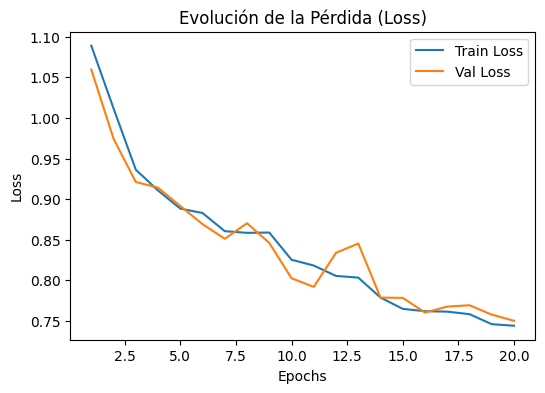

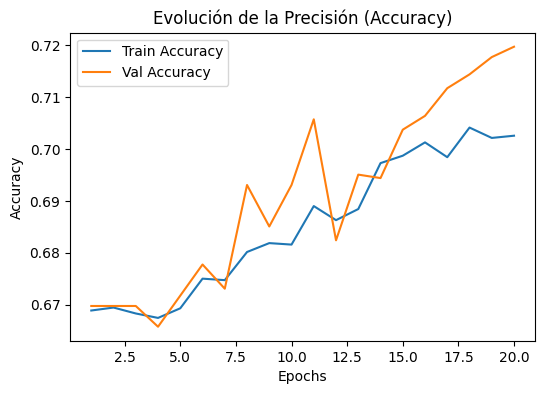

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, hist["loss"], label="Train Loss")
plt.plot(epochs, hist["val_loss"], label="Val Loss")
plt.title("Evolución de la Pérdida (Loss)")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, hist["accuracy"], label="Train Accuracy")
plt.plot(epochs, hist["val_accuracy"], label="Val Accuracy")
plt.title("Evolución de la Precisión (Accuracy)")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

# Las curvas se ven bien: la pérdida baja y la precisión sube de forma estable.
No hay signos de sobreajuste, así que el entrenamiento fue correcto.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

y_true = test_df["dx"].map(class_to_idx).values
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(
    y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(class_names))]
))

47/47 ━━━━━━━━━━━━━━━━━━━━ 421s 9s/step
              precision    recall  f1-score   support

       akiec       1.00      0.02      0.04        49
         bcc       0.39      0.38      0.38        77
         bkl       0.36      0.38      0.37       165
          df       0.00      0.00      0.00        17
         mel       0.39      0.17      0.24       167
          nv       0.79      0.91      0.84      1006
        vasc       0.57      0.55      0.56        22

    accuracy                           0.70      1503
   macro avg       0.50      0.34      0.35      1503
weighted avg       0.67      0.70      0.66      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Data Augmentation y Class Weights

from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# Pesos por clase
counts = Counter(train_df["dx"])
num_classes = len(class_names)
total = sum(counts.values())
class_weight = {class_to_idx[c]: total / (num_classes * counts[c]) for c in counts}

# Augmentación - train
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
], name="augment")

def load_image_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = augment(img)
    return img, tf.one_hot(label, depth=num_classes)

def make_ds_aug(df_part, shuffle=False):
    paths = df_part["image_path"].values
    labels = df_part["dx"].map(class_to_idx).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image_aug, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds_aug = make_ds_aug(train_df, shuffle=True)

# Comparar modelo con nuevo
def make_model_baseline(num_classes=num_classes):
    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model_aug = make_model_baseline()
PROJECT_DIR = "/content/drive/MyDrive/HAM10000_Project"
MODELS_DIR = os.path.join(PROJECT_DIR, "models"); os.makedirs(MODELS_DIR, exist_ok=True)
ckpt_aug = os.path.join(MODELS_DIR, "baseline_cnn_aug_classweights.h5")

callbacks_aug = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5),
    ModelCheckpoint(ckpt_aug, save_best_only=True)
]

history_aug = model_aug.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight,
    callbacks=callbacks_aug,
    verbose=1
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1799 - loss: 1.9452 

220/220 ━━━━━━━━━━━━━━━━━━━━ 1675s 7s/step - accuracy: 0.1804 - loss: 1.9451 - val_accuracy: 0.3142 - val_loss: 1.7528 - learning_rate: 0.0010
Epoch 2/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.3811 - loss: 1.8172

220/220 ━━━━━━━━━━━━━━━━━━━━ 134s 536ms/step - accuracy: 0.3810 - loss: 1.8170 - val_accuracy: 0.4001 - val_loss: 1.5985 - learning_rate: 0.0010
Epoch 3/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.3829 - loss: 1.6981

220/220 ━━━━━━━━━━━━━━━━━━━━ 129s 517ms/step - accuracy: 0.3828 - loss: 1.6980 - val_accuracy: 0.3642 - val_loss: 1.5864 - learning_rate: 0.0010
Epoch 4/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3381 - loss: 1.5996

220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 522ms/step - accuracy: 0.3380 - loss: 1.5999 - val_accuracy: 0.4081 - val_loss: 1.3871 - learning_rate: 0.0010
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 139s 511ms/step - accuracy: 0.3809 - loss: 1.5107 - val_accuracy: 0.2177 - val_loss: 1.8016 - learning_rate: 0.0010
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 514ms/step - accuracy: 0.3461 - loss: 1.5588 - val_accuracy: 0.3901 - val_loss: 1.4071 - learning_rate: 0.0010
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.3882 - loss: 1.5028

220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 523ms/step - accuracy: 0.3881 - loss: 1.5028 - val_accuracy: 0.3928 - val_loss: 1.3064 - learning_rate: 5.0000e-04
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 149s 557ms/step - accuracy: 0.4098 - loss: 1.5197 - val_accuracy: 0.4294 - val_loss: 1.5099 - learning_rate: 5.0000e-04
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 134s 514ms/step - accuracy: 0.4308 - loss: 1.4287 - val_accuracy: 0.4361 - val_loss: 1.4470 - learning_rate: 5.0000e-04
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 139s 509ms/step - accuracy: 0.4660 - loss: 1.3997 - val_accuracy: 0.4767 - val_loss: 1.3830 - learning_rate: 2.5000e-04
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 152s 556ms/step - accuracy: 0.4606 - loss: 1.3840 - val_accuracy: 0.4880 - val_loss: 1.3715 - learning_rate: 2.5000e-04
Epoch 12/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 139s 561ms/step - accuracy: 0.4808 - loss: 1.3658 - val_accuracy: 0.4860 - val_loss: 1.3564 - learning_rate: 1.2500e-04


# El modelo con data augmentation y class weights completó 12 de 20 épocas con una accuracy y val_accuracy de 0.48
No mejoró frente al baseline, por lo que el desbalance de clases sigue afectando el rendimiento pese al reequilibrio aplicado.

In [ ]:
# Test - Data Augmentation + Class Weights

import numpy as np
from sklearn.metrics import classification_report

y_true = test_df["dx"].map(class_to_idx).values
y_prob = model_aug.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(
    y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(class_names))])
)

47/47 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.22      0.26      0.24        77
         bkl       0.20      0.21      0.21       165
          df       0.04      0.29      0.06        17
         mel       0.19      0.75      0.30       167
          nv       0.95      0.38      0.54      1006
        vasc       0.45      0.64      0.53        22

    accuracy                           0.39      1503
   macro avg       0.29      0.36      0.27      1503
weighted avg       0.70      0.39      0.44      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#El modelo con data augmentation y class weights logró un 49 % de precisión, similar al baseline.
Destaca la clase “nv” con un 95%, pero las minoritarias siguen con bajo rendimiento.
Se ve leve mejora en la generalización.

In [ ]:
# Transfer Learning con ResNet50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os, tensorflow as tf

NUM_CLASSES = len(class_names)

# Base preentrenada
base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False  # congelamos capas base

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(preprocess_input)(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

resnet_model = models.Model(inputs, outputs)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

ckpt_resnet_tl = os.path.join(MODELS_DIR, "resnet50_tl_best.h5")
callbacks_resnet_tl = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5),
    ModelCheckpoint(ckpt_resnet_tl, save_best_only=True),
]

history_resnet_tl = resnet_model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=12,
    callbacks=callbacks_resnet_tl,
    verbose=1
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5748 - loss: 1.4096

220/220 ━━━━━━━━━━━━━━━━━━━━ 163s 611ms/step - accuracy: 0.5750 - loss: 1.4092 - val_accuracy: 0.6698 - val_loss: 1.1349 - learning_rate: 1.0000e-04
Epoch 2/12
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6640 - loss: 1.2218

220/220 ━━━━━━━━━━━━━━━━━━━━ 145s 588ms/step - accuracy: 0.6640 - loss: 1.2217 - val_accuracy: 0.6698 - val_loss: 1.1327 - learning_rate: 1.0000e-04
Epoch 3/12
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6763 - loss: 1.1773

220/220 ━━━━━━━━━━━━━━━━━━━━ 148s 594ms/step - accuracy: 0.6762 - loss: 1.1775 - val_accuracy: 0.6698 - val_loss: 1.1303 - learning_rate: 1.0000e-04
Epoch 4/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 134s 535ms/step - accuracy: 0.6731 - loss: 1.1752 - val_accuracy: 0.6698 - val_loss: 1.1355 - learning_rate: 1.0000e-04
Epoch 5/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 578ms/step - accuracy: 0.6717 - loss: 1.1740 - val_accuracy: 0.6698 - val_loss: 1.1317 - learning_rate: 1.0000e-04
Epoch 6/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 134s 539ms/step - accuracy: 0.6775 - loss: 1.1558 - val_accuracy: 0.6698 - val_loss: 1.1304 - learning_rate: 5.0000e-05
Epoch 7/12
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6742 - loss: 1.1517

220/220 ━━━━━━━━━━━━━━━━━━━━ 145s 552ms/step - accuracy: 0.6742 - loss: 1.1518 - val_accuracy: 0.6698 - val_loss: 1.1293 - learning_rate: 5.0000e-05
Epoch 8/12
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6741 - loss: 1.1598

220/220 ━━━━━━━━━━━━━━━━━━━━ 147s 593ms/step - accuracy: 0.6741 - loss: 1.1598 - val_accuracy: 0.6698 - val_loss: 1.1292 - learning_rate: 5.0000e-05
Epoch 9/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 136s 543ms/step - accuracy: 0.6714 - loss: 1.1553 - val_accuracy: 0.6698 - val_loss: 1.1295 - learning_rate: 5.0000e-05
Epoch 10/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 133s 538ms/step - accuracy: 0.6751 - loss: 1.1488 - val_accuracy: 0.6698 - val_loss: 1.1293 - learning_rate: 5.0000e-05
Epoch 11/12
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6737 - loss: 1.1429

220/220 ━━━━━━━━━━━━━━━━━━━━ 136s 551ms/step - accuracy: 0.6737 - loss: 1.1430 - val_accuracy: 0.6698 - val_loss: 1.1289 - learning_rate: 2.5000e-05
Epoch 12/12
220/220 ━━━━━━━━━━━━━━━━━━━━ 135s 539ms/step - accuracy: 0.6749 - loss: 1.1516 - val_accuracy: 0.6698 - val_loss: 1.1290 - learning_rate: 2.5000e-05


#ResNet50 mejoró el rendimiento acc 0.67, val_acc 0.66 respecto al baseline.
Entrenamiento estable y no tuvo sobreajuste, se piuede seguir afinando.

In [ ]:
# ResNet50 Fine-tuning - últimas capas !

base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

ckpt_resnet_ft = os.path.join(MODELS_DIR, "resnet50_finetune_best.h5")
callbacks_resnet_ft = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5),
    ModelCheckpoint(ckpt_resnet_ft, save_best_only=True),
]

history_resnet_ft = resnet_model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_resnet_ft,
    verbose=1
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6857 - loss: 1.0323

220/220 ━━━━━━━━━━━━━━━━━━━━ 183s 647ms/step - accuracy: 0.6857 - loss: 1.0322 - val_accuracy: 0.6698 - val_loss: 1.1936 - learning_rate: 1.0000e-05
Epoch 2/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6916 - loss: 0.9322

220/220 ━━━━━━━━━━━━━━━━━━━━ 148s 601ms/step - accuracy: 0.6915 - loss: 0.9321 - val_accuracy: 0.6858 - val_loss: 0.9070 - learning_rate: 1.0000e-05
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 203s 610ms/step - accuracy: 0.6992 - loss: 0.8848 - val_accuracy: 0.7037 - val_loss: 0.9244 - learning_rate: 1.0000e-05
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 139s 565ms/step - accuracy: 0.7046 - loss: 0.8576 - val_accuracy: 0.6778 - val_loss: 1.3301 - learning_rate: 1.0000e-05
Epoch 5/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.7105 - loss: 0.8207

220/220 ━━━━━━━━━━━━━━━━━━━━ 144s 582ms/step - accuracy: 0.7104 - loss: 0.8207 - val_accuracy: 0.7111 - val_loss: 0.8269 - learning_rate: 5.0000e-06
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 149s 564ms/step - accuracy: 0.7140 - loss: 0.8027 - val_accuracy: 0.7257 - val_loss: 0.8503 - learning_rate: 5.0000e-06
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 193s 567ms/step - accuracy: 0.7169 - loss: 0.7893 - val_accuracy: 0.6944 - val_loss: 1.0978 - learning_rate: 5.0000e-06
Epoch 8/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.7211 - loss: 0.7806

220/220 ━━━━━━━━━━━━━━━━━━━━ 156s 641ms/step - accuracy: 0.7211 - loss: 0.7805 - val_accuracy: 0.7437 - val_loss: 0.7733 - learning_rate: 2.5000e-06
Epoch 9/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7396 - loss: 0.7370

220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 623ms/step - accuracy: 0.7395 - loss: 0.7370 - val_accuracy: 0.7297 - val_loss: 0.7619 - learning_rate: 2.5000e-06
Epoch 10/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.7351 - loss: 0.7203

220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 620ms/step - accuracy: 0.7350 - loss: 0.7204 - val_accuracy: 0.7377 - val_loss: 0.7459 - learning_rate: 2.5000e-06


# El fine-tuning de ResNet50 alcanzó acc y val_acc de 0.73
con pérdidas de 0.74
El modelo mostró buen equilibrio y es el mejor resultado obtenido hasta ahora, y con esto cierro el Hito 3

In [ ]:
# Evaluación final del modelo ajustado (ResNet-50 fine-tuned)

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import os

MODEL_PATH = os.path.join(MODELS_DIR, "resnet50_finetune_best.h5")  # ajustado según tu ls

# Cargar el modelo registrando la función usada en la Lambda
resnet_model = load_model(MODEL_PATH, custom_objects={'preprocess_input': preprocess_input})

# Evaluación en test
test_loss, test_acc = resnet_model.evaluate(test_ds, verbose=1)
print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 333ms/step - accuracy: 0.7377 - loss: 0.7594
Loss en test: 0.7692
Accuracy en test: 0.7285


# El modelo ResNet-50 fine-tuned alcanzó una precisión del 73 % y una pérdida de 0.77 en el conjunto de test.
Muestra una mejora clara respecto a los modelos previos (baseline y augmentation + class weights), con buena generalización y sin sobreajuste notable.

# Terminada la Práctica Final de Deep Learning (HAM10000) !!!!!!!